# Intrinsics

## Indexing

### Subscript

A subscript is a mapping from the dimensions (axes of the shape) to a collection of indexes along this axis.

Let's say $n_d$ is the number of dimensions of an array $A$, and $d_0, d_1, ... d_{n_d}$ are the sizes along those dimensions. We can further define $F$, a filter as a sequence $(f_0, f_1, ... f_{n_d})$ where for any $i$, $f_i$ is the sequence of selected indexes along this axis. 

If $(i_0, i_1, ..., i_{n_d})$ are the indexes of an element in $A$ and $D$ is the (flat) buffer storing this data, then:

$$A(i_0, i_1, ..., i_{n_d}) = D(\sum_{k=0}^{n_d} i_k s_k)$$

where the $s_i$ are the strides of $A$.

$$\forall i \in \{0, 1, ..., n_d - 1\}, s_i = \prod_{k=i+1}^{n_d} d_k \text{ and } s_{n_d} = 1$$

If we have $I = \sum_{k=0}^{n_d} i_k s_k$ then if we want to find $I'$ for $i_{k_{new}}$ for example: we can do $I' = I + s_k(i_{k_{new}} - i_k)$


$f(u) = ln(u)$

$f'(u) = \frac{1}{u}$

$f(v) = softmax(v) = \frac{e^v}{reduce\_sum(e^v)} = \frac{e^v}{\sum e^{v_i}}$
$f(v)_i = softmax(v)_i = \frac{e^{v_i}}{\sum_j e^{v_j}}$

$f'(v)_i = \frac{e^{v_i} \sum_j e^{v_j} - e^{2v_i}}{(\sum_j e^{v_j})^2} = softmax(v)_i - softmax(v)_i^2$

$f'(v) = softmax(v) - softmax(v)^2$



$L(y, u) = -\sum y_i$

In [148]:
import networkx as nx
import dis
import matplotlib.pyplot as plt

style = {
    'with_labels': True, 
    'font_weight': 'bold',
    'arrowsize': 20,
    'node_size': 2000, 
    'node_color': '#faa19b'
}

def f(x, W1, W2, b):
    x = relu(W1 @ x + b)
    x = softmax(W2 @ x)
    return x


 14           0 LOAD_GLOBAL              0 (relu)
              2 LOAD_FAST                1 (W1)
              4 LOAD_FAST                0 (x)
              6 BINARY_MATRIX_MULTIPLY
              8 LOAD_FAST                3 (b)
             10 BINARY_ADD
             12 CALL_FUNCTION            1
             14 STORE_FAST               0 (x)

 15          16 LOAD_GLOBAL              1 (softmax)
             18 LOAD_FAST                2 (W2)
             20 LOAD_FAST                0 (x)
             22 BINARY_MATRIX_MULTIPLY
             24 CALL_FUNCTION            1
             26 STORE_FAST               0 (x)

 16          28 LOAD_FAST                0 (x)
             30 RETURN_VALUE
('x', {'offset': 0, 'group': 6})
('W1', {'offset': 0, 'group': 6})
('W2', {'offset': 0, 'group': 3})
('b', {'offset': 0, 'group': 5})
('BINARY_MATRIX_MULTIPLY_6', {'group': 5})
('BINARY_ADD_10', {'group': 4})
('relu_12', {'group': 3})
('BINARY_MATRIX_MULTIPLY_22', {'group': 2})
('softmax_24', {'g

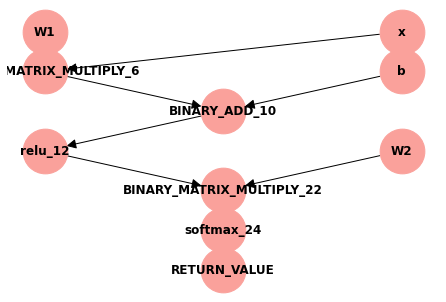

In [150]:


def computation_graph(f):
    G = nx.DiGraph()
    bytecode = dis.Bytecode(f)
    stack = []
    mapping = {}
    for a in bytecode.codeobj.co_varnames:
        G.add_node(a, offset=0)
        mapping[a] = a
    dis.dis(f)
    for byte in bytecode:
        # print(byte)
        if byte.opname in ['LOAD_FAST']:
            stack.append(mapping[byte.argval])
        if byte.opname in ['LOAD_CONST']:
            stack.append(byte.argval)
        if byte.opname in ['LOAD_GLOBAL']:
            stack.append(byte.argval)
        if byte.opname in ['BINARY_ADD', 'BINARY_POWER', 'BINARY_MATRIX_MULTIPLY']:
            a = stack.pop()
            b = stack.pop()
            val = byte.opname + "_" + str(byte.offset)
            stack.append(val)
            G.add_edge(a, val)
            G.add_edge(b, val)
        if byte.opname in ['STORE_FAST']:
            mapping[byte.argval] = stack.pop()
        if byte.opname in ['CALL_FUNCTION']:
            arg = stack.pop()
            f = stack.pop()
            val = f + "_" + str(byte.offset)
            stack.append(val)
            G.add_edge(arg, val)
        if byte.opname in ['RETURN_VALUE']:
            arg = stack.pop()
            G.add_edge(arg, byte.opname)
    def group(graph, node, depth):
        graph.nodes[node]['group'] = depth
        for n in graph.predecessors(node):
            group(graph, n, depth + 1)
    group(G, 'RETURN_VALUE', 0)
    return G
            
            

G = computation_graph(f)

nx.draw(G,
        pos = nx.multipartite_layout(G, align='horizontal', subset_key="group"), 
        **style)
for n in G.nodes(data=True):
    print(n)

In [97]:
bytecode = dis.Bytecode(f)
for att in dir(bytecode.codeobj):
    if "__" not in att:
        print(att, " :", getattr(bytecode.codeobj, att))

co_argcount  : 1
co_cellvars  : ()
co_code  : b't\x00t\x01|\x00\x10\x00t\x02\x17\x00\x83\x01}\x00t\x03t\x04|\x00\x10\x00\x83\x01}\x00|\x00S\x00'
co_consts  : (None,)
co_filename  : <ipython-input-79-115a6fb89f37>
co_firstlineno  : 12
co_flags  : 67
co_freevars  : ()
co_kwonlyargcount  : 0
co_lnotab  : b'\x00\x01\x10\x01\x0c\x01'
co_name  : f
co_names  : ('relu', 'W1', 'b', 'softmax', 'W2')
co_nlocals  : 1
co_posonlyargcount  : 0
co_stacksize  : 3
co_varnames  : ('x',)
replace  : <built-in method replace of code object at 0x000001F66EB1DBE0>
